In [1]:
# tables
import pandas as pd
import numpy as np
# graphics
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocecing
from nltk.corpus import stopwords
import nltk
import collections
import re
from bs4 import BeautifulSoup

#LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

#gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import gensim

#essai
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans

#Supervisée
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

#models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier

#metrics
from sklearn.metrics import hamming_loss,accuracy_score, classification_report,jaccard_score,f1_score

#GridSearchCV
from time import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#On ignore les DeprecationWarning car un souci lié à pyLDAvis en affiche beaucoup 
#mais mon mentor et moi meme n'avons pas réussi à résoudre le problème.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# P5-IML-Catégorisez automatiquement des questions

In [2]:
#Import des datasets 
df=pd.read_csv("QueryResults_1.csv", sep=',',encoding = 'UTF-8')
df=df.append(pd.read_csv("QueryResults_2.csv", sep=',',encoding = 'UTF-8'),ignore_index = True)

In [3]:
print("Body")
print(df.Body.shape)
print(df.Body.drop_duplicates().shape)
print("Title")
print(df.Title.shape)
print(df.Title.drop_duplicates().shape)
print("Tags")
print(df.Tags.shape)
print(df.Tags.drop_duplicates().shape)

Body
(58903,)
(58903,)
Title
(58903,)
(58898,)
Tags
(58903,)
(41457,)


In [4]:
df.shape

(58903, 4)

# Les prétraitements

### Fonctions

In [5]:
#fontion de 'tokenisation' pour df.Title et df.Body
def token(text):
    text=re.sub('[^a-zA-Z0-9#+]', ' ',BeautifulSoup(text, "lxml").get_text() ).lower().split()
    return text

In [6]:
stop = stopwords.words('english')

In [7]:
sno = nltk.stem.SnowballStemmer('english')
def stemmer(s):
    s = [sno.stem(word) for word in s if word not in (stop)]
    return s

### Body

In [8]:
df.Body.iloc[0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double\n</code></pre>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'

In [9]:
df.Body=df.Body.map(token)

In [10]:
df.Body

0        [i, want, to, use, a, track, bar, to, change, ...
1        [i, have, an, absolutely, positioned, div, con...
2        [given, a, datetime, representing, a, person, ...
3        [given, a, specific, datetime, value, how, do,...
4        [is, there, a, standard, way, for, a, web, ser...
                               ...                        
58898    [every, time, i, try, npm, install, i, get, th...
58899    [i, am, reading, a, book, programming, with, p...
58900    [we, re, currently, migrating, from, java, 8, ...
58901    [all, of, a, sudden, i, am, getting, this, bui...
58902    [i, have, a, fairly, complex, maths, library, ...
Name: Body, Length: 58903, dtype: object

In [11]:
df.Body=df.Body.apply(stemmer)

In [12]:
df.Body

0        [want, use, track, bar, chang, form, opac, cod...
1        [absolut, posit, div, contain, sever, children...
2        [given, datetim, repres, person, birthday, cal...
3        [given, specif, datetim, valu, display, relat,...
4        [standard, way, web, server, abl, determin, us...
                               ...                        
58898    [everi, time, tri, npm, instal, get, follow, e...
58899    [read, book, program, posix, thread, butenhof,...
58900    [current, migrat, java, 8, java, 11, howev, up...
58901    [sudden, get, build, error, android, project, ...
58902    [fair, complex, math, librari, work, discov, n...
Name: Body, Length: 58903, dtype: object

### Title

In [13]:
df=df.drop_duplicates(subset=['Title'])

In [14]:
df.Title.iloc[0]

'How to convert a Decimal to a Double in C#?'

In [15]:
df.Title

0              How to convert a Decimal to a Double in C#?
1        Why did the width collapse in the percentage w...
2        How do I calculate someone's age based on a Da...
3                            Calculate relative time in C#
4                              Determine a user's timezone
                               ...                        
58898    `npm install` fails on node-gyp rebuild with `...
58899                Why cast free's return value to void?
58900    Is there any need to switch to modules when mi...
58901    How to fix "unexpected element <queries> found...
58902    How can I make my class immune to the "auto va...
Name: Title, Length: 58898, dtype: object

In [16]:
df.Title=df.Title.map(token)

In [17]:
df.Title=df.Title.apply(stemmer)

In [18]:
df.Title

0                              [convert, decim, doubl, c#]
1        [width, collaps, percentag, width, child, elem...
2        [calcul, someon, age, base, datetim, type, bir...
3                                [calcul, relat, time, c#]
4                                [determin, user, timezon]
                               ...                        
58898    [npm, instal, fail, node, gyp, rebuild, gyp, x...
58899                     [cast, free, return, valu, void]
58900    [need, switch, modul, migrat, java, 9+, java, 11]
58901               [fix, unexpect, element, found, error]
58902    [make, class, immun, auto, valu, copi, proxi, ...
Name: Title, Length: 58898, dtype: object

### Tags

In [19]:
df.Tags.iloc[0]

'<c#><floating-point><type-conversion><double><decimal>'

In [20]:
df.Tags=df["Tags"].map(lambda field:field[1:-1].split('><'))

In [21]:
df.Tags

0        [c#, floating-point, type-conversion, double, ...
1                         [html, css, internet-explorer-7]
2                                     [c#, .net, datetime]
3        [c#, datetime, time, datediff, relative-time-s...
4        [html, browser, timezone, user-agent, timezone...
                               ...                        
58898    [node.js, npm, terminal, macos-catalina, node-...
58899                [c, casting, free, void, legacy-code]
58900         [java, java-11, java-platform-module-system]
58901    [android, android-gradle-plugin, android-manif...
58902                               [c++, copy-assignment]
Name: Tags, Length: 58898, dtype: object

In [22]:
df

,Id,Body,Title,Tags
0,4,"[want, use, track, bar, chang, form, opac, cod...","[convert, decim, doubl, c#]","[c#, floating-point, type-conversion, double, ..."
1,6,"[absolut, posit, div, contain, sever, children...","[width, collaps, percentag, width, child, elem...","[html, css, internet-explorer-7]"
2,9,"[given, datetim, repres, person, birthday, cal...","[calcul, someon, age, base, datetim, type, bir...","[c#, .net, datetime]"
3,11,"[given, specif, datetim, valu, display, relat,...","[calcul, relat, time, c#]","[c#, datetime, time, datediff, relative-time-s..."
4,13,"[standard, way, web, server, abl, determin, us...","[determin, user, timezon]","[html, browser, timezone, user-agent, timezone..."
...,...,...,...,...
58898,60573595,"[everi, time, tri, npm, instal, get, follow, e...","[npm, instal, fail, node, gyp, rebuild, gyp, x...","[node.js, npm, terminal, macos-catalina, node-..."
58899,60625906,"[read, book, program, posix, thread, butenhof,...","[cast, free, return, valu, void]","[c, casting, free, void, legacy-code]"
58900,62950667,"[current, migrat, java, 8, java, 11, howev, up...","[need, switch, modul, migrat, java, 9+, java, 11]","[java, java-11, java-platform-module-system]"
58901,62969917,"[sudden, get, build, error, android, project, ...","[fix, unexpect, element, found, error]","[android, android-gradle-plugin, android-manif..."


# Analyse univariée

## Analyse et gestion des tags

C:\Users\thiba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


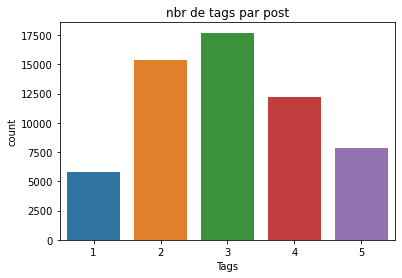

In [23]:
sns.countplot(df.Tags.map(lambda field:len(field)))
plt.title("nbr de tags par post")
plt.show()

In [24]:
all_tags=[]
for i in df.Tags:
    for j in i:
        all_tags.append(j)

C:\Users\thiba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


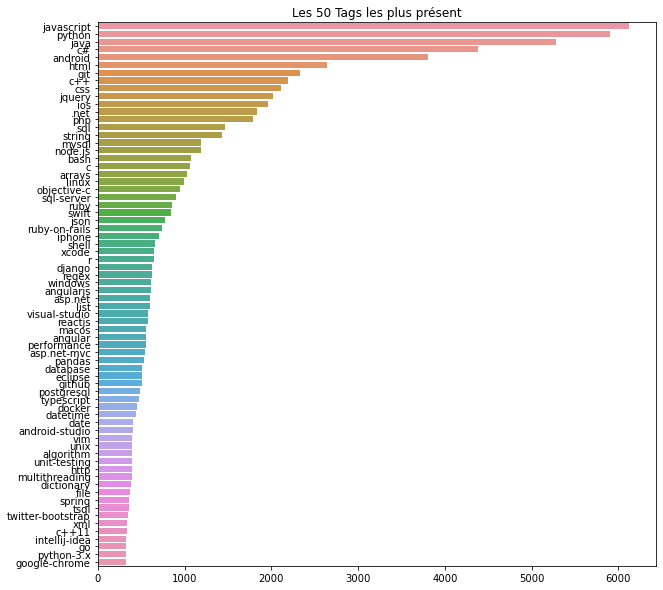

In [25]:
#Affichage des 70 Tags les plus présent
counter=collections.Counter(all_tags)
common = counter.most_common(70)
labels = [item[0] for item in common]
number = [item[1] for item in common]

plt.figure(figsize=(10,10))
sns.barplot(number, labels)
plt.title("Les 50 Tags les plus présent")
plt.show()

In [26]:
liste=[]
for i in range(0,len(labels)):
    if number[i]>500:
        liste.append(labels[i])    

In [27]:
def tags_to_keep(list):
    list = [x for x in list if x in liste]
    return list

In [28]:
df.Tags=df.Tags.apply(tags_to_keep)

In [29]:
df=df.reset_index()
df=df.drop(['index'],axis=1)

In [30]:
index_to_drop=[]
for i in range(0,len(df)-1):
    if len(df.Tags[i])==0:
        index_to_drop.append(i)

In [31]:
df.Tags=df.Tags.drop(index=index_to_drop,axis=0)

In [32]:
df=df.dropna()

C:\Users\thiba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


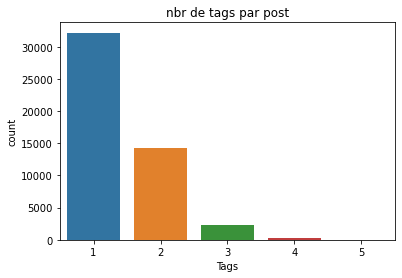

In [33]:
sns.countplot(df.Tags.map(lambda field:len(field)))
plt.title("nbr de tags par post")
plt.show()

## Analyse du texte

In [34]:
df["Document"] = (df.Title + df.Body)
df=df.drop(["Title", "Body"], axis=1)

In [35]:
all_words=[]
for i in df.Document:
    for j in i:
        all_words.append(j)

C:\Users\thiba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


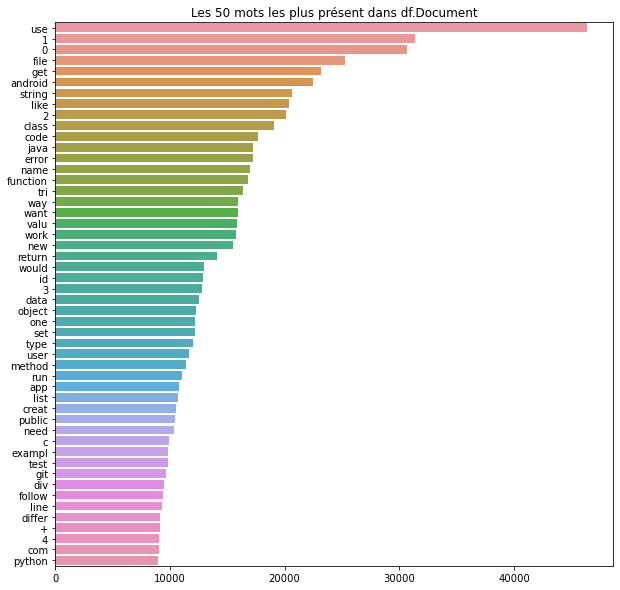

In [36]:
#Affichage des 50 mots les plus présent dans df.Document
counter=collections.Counter(all_words)
common = counter.most_common(50)
labels = [item[0] for item in common]
number = [item[1] for item in common]

plt.figure(figsize=(10,10))
sns.barplot(number, labels)
plt.title("Les 50 mots les plus présent dans df.Document")
plt.show()

# Mettre en œuvre une approche non supervisée.

# LDA

In [37]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)
tfidf = tfidf_vectorizer.fit_transform(df.Document)

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

In [39]:
lda =  LatentDirichletAllocation(n_components = 4)

In [40]:
lda.fit(tfidf)

LatentDirichletAllocation(n_components=4)

In [41]:
lda.perplexity(tfidf)

3333.0139101335976

In [42]:
lda.score(tfidf)

-1836747.4820928741

In [43]:
pyLDAvis.sklearn.prepare(lda,tfidf,tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.111815 -0.037463       1        1  33.460852
0      0.106013  0.076437       2        1  26.658021
3     -0.068500 -0.120431       3        1  22.528953
2     -0.149328  0.081458       4        1  17.352175, topic_info=         Term         Freq        Total Category  logprob  loglift
300   android   705.000000   705.000000  Default  30.0000  30.0000
1816      git   604.000000   604.000000  Default  29.0000  29.0000
1547     file  1102.000000  1102.000000  Default  28.0000  28.0000
4049   string   996.000000   996.000000  Default  27.0000  27.0000
2156   instal   394.000000   394.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
4237     test   133.697785   468.145901   Topic4  -5.6832   0.4983
4542      use   176.569023  1356.225506   Topic4  -5.4050  -0.2873
4371      tri   137.778672   610.830405   Topic4  -5.6531   0.2623
3799      set   130.975965   562.026064   Topic4  -5.7037   0.2949
1762      get   132.078108   852.528688   Topic4  -5.6954  -0.1134

[330 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.056921     00
0         2  0.872785     00
0         4  0.066408     00
1         2  0.972133  00 00
1         4  0.023711  00 00
...     ...       ...    ...
4960      2  0.240093    xml
4960      3  0.017150    xml
4960      4  0.720280    xml
4965      4  0.984488  xmlns
4986      1  0.964359   yyyi

[663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

In [44]:
def plot_tsne_pca(data, labels):
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max(labels)) for i in label_subset[idx]]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

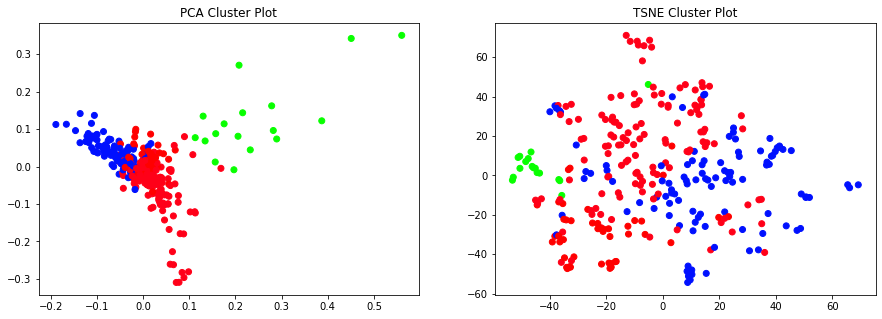

In [45]:
clusters = MiniBatchKMeans(n_clusters=4, random_state=20).fit_predict(tfidf)
plot_tsne_pca(tfidf, clusters)

In [46]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = 4
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(tfidf)

print("Topics found via LDA:")
print_topics(lda, tfidf_vectorizer, number_words)

Topics found via LDA:

Topic #0:
file use python list array string object function class code

Topic #1:
string tabl data date valu column use get id sql

Topic #2:
git class commit button branch chang div view use text

Topic #3:
android imag instal app project div use studio file error


### SKLearn

In [47]:
#Boucle sur LDA
dict={}
for i in [2,4,6,10]:
    #,4,6,10,12
    lda =  LatentDirichletAllocation(n_components = i).fit(tfidf)
    perp=lda.perplexity(tfidf)
    dict[i]=perp

In [48]:
dict

{2: 2752.123649218644,
 4: 3154.971236661678,
 6: 3612.255314467841,
 10: 4216.546659102981}

### Ou avec Gensim

In [49]:
id2word = corpora.Dictionary(df.Document)

texts = df.Document

corpus = [id2word.doc2bow(text) for text in texts]

In [50]:
#Boucle sur LdaMulticore
dict={}
for i in  np.arange(2,12,2) :
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df.Document, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    dict[i]=coherence_lda
    print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38280329930799095
Coherence Score:  0.46999458436329916
Coherence Score:  0.5398770976198571
Coherence Score:  0.584074521760256
Coherence Score:  0.5608615498506905


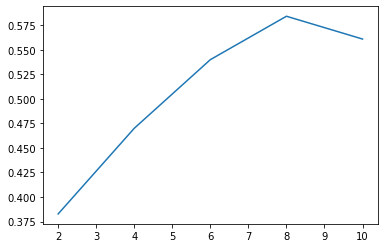

In [51]:
plt.plot(*zip(*sorted(dict.items())))
plt.show()

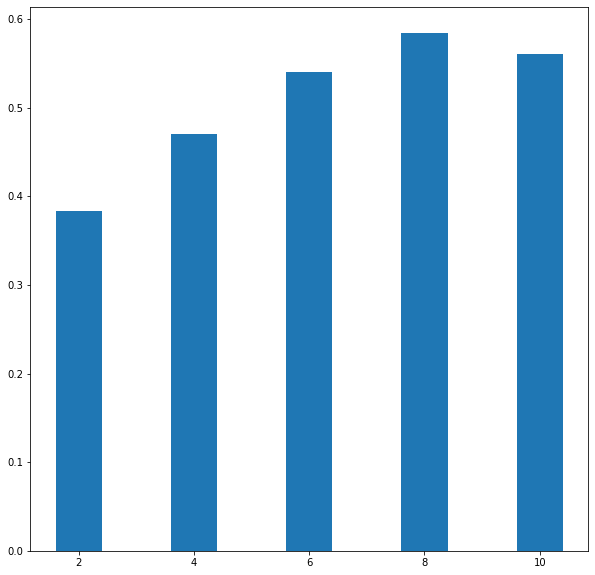

In [52]:
keys = dict.keys()
values = dict.values()

plt.figure(figsize=(10,10))
plt.bar(keys, values)
plt.show()

In [53]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [54]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [55]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.144644  0.013703       1        1  22.023250
5     -0.015393 -0.137027       2        1  14.941956
2     -0.037702 -0.215920       3        1  13.561170
3     -0.132657 -0.061813       4        1  12.403447
0     -0.080425  0.094596       5        1  11.629493
7     -0.113901  0.116398       6        1  10.660229
6      0.122258  0.257295       7        1   9.261057
4      0.402464 -0.067232       8        1   5.519398, topic_info=         Term          Freq         Total Category  logprob  loglift
32          0  34152.000000  34152.000000  Default  30.0000  30.0000
4126  android  25176.000000  25176.000000  Default  29.0000  29.0000
155         1  31878.000000  31878.000000  Default  28.0000  28.0000
550      java  16779.000000  16779.000000  Default  27.0000  27.0000
293      file  21691.000000  21691.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
788        10   1150.457917   5649.378315   Topic8  -5.1592   1.3055
2597     self   1070.375393   4834.484636   Topic8  -5.2313   1.3891
1017     core   1006.592446   3259.144215   Topic8  -5.2928   1.7220
375       run   1055.722191  11625.253059   Topic8  -5.2451   0.4979
567    method    955.435497  10972.533280   Topic8  -5.3449   0.4559

[577 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
147        1  0.081033           #
147        2  0.418611           #
147        4  0.082779           #
147        6  0.118580           #
147        7  0.299157           #
...      ...       ...         ...
260        7  0.758833           x
2586       3  0.960367       xcode
2586       7  0.039400       xcode
3157       6  0.997321        yyyi
11286      8  0.999357  zygoteinit

[1513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 4, 1, 8, 7, 5])

# Utiliser une approche supervisée

In [56]:
df=df.reset_index()
df=df.drop(['index'],axis=1)

In [57]:
X = df["Document"].apply(lambda x: ' '.join(x))
y = df["Tags"]

In [58]:
multilabel_binarizer = MultiLabelBinarizer()
y = multilabel_binarizer.fit_transform(y)

In [59]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=.8,
    min_df=5,
    max_features=20000,
    ngram_range=(1, 1)
)
X= tfidf_vectorizer.fit_transform(X)

In [60]:
multilabel_binarizer.classes_

array(['.net', 'android', 'angular', 'angularjs', 'arrays', 'asp.net',
       'asp.net-mvc', 'bash', 'c', 'c#', 'c++', 'css', 'database',
       'django', 'eclipse', 'git', 'github', 'html', 'ios', 'iphone',
       'java', 'javascript', 'jquery', 'json', 'linux', 'list', 'macos',
       'mysql', 'node.js', 'objective-c', 'pandas', 'performance', 'php',
       'python', 'r', 'reactjs', 'regex', 'ruby', 'ruby-on-rails',
       'shell', 'sql', 'sql-server', 'string', 'swift', 'visual-studio',
       'windows', 'xcode'], dtype=object)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [62]:
svc = LinearSVC(random_state=0)
forest = RandomForestClassifier(random_state=0)
perceptron = Perceptron(random_state=0)
lr = LogisticRegression(random_state=0)
sgd = SGDClassifier(random_state=0)
gbc=GradientBoostingClassifier(random_state=0)

In [63]:
y_train[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [64]:
classifier=[svc,forest,perceptron,lr,sgd,gbc]

In [65]:
results = pd.DataFrame({})
def errors(name,model,X_train, y_train,X_test,y_test):
    global results
    clf = MultiOutputClassifier(model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results = results.append(pd.DataFrame({
        'Modèle': [name],
        'Hamming_loss':hamming_loss(y_pred, y_test),
        'Jaccard_score':jaccard_score(y_pred, y_test,average='macro')*100,
        'Accuracy_score':accuracy_score(y_pred, y_test),
        'Macro_f1_score':f1_score(y_test, y_pred,average='macro'),
        'Micro_f1_score':f1_score(y_test, y_pred,average='micro')}),ignore_index=True)

In [66]:
for i in classifier:
    errors(str(i),i,X_train, y_train,X_test,y_test)

In [67]:
results

,Modèle,Hamming_loss,Jaccard_score,Accuracy_score,Macro_f1_score,Micro_f1_score
0,LinearSVC(random_state=0),0.013872,54.184744,0.517808,0.678776,0.735347
1,RandomForestClassifier(random_state=0),0.016878,34.853603,0.423717,0.460438,0.627284
2,Perceptron(),0.019312,48.549593,0.431166,0.630956,0.673111
3,LogisticRegression(random_state=0),0.016417,42.432124,0.430248,0.568753,0.655300
4,SGDClassifier(random_state=0),0.015694,44.519150,0.451475,0.572157,0.671036
5,GradientBoostingClassifier(random_state=0),0.016113,50.667718,0.452903,0.643468,0.691550


In [68]:
t0 = time()
pipeline = Pipeline([('clf', MultiOutputClassifier(LinearSVC()))])
parameters = {
     "clf__estimator__C": np.arange(1,20,2),     
     "clf__estimator__max_iter":[1000, 10000, 20000]
}

model_tunning = GridSearchCV(pipeline, parameters, cv=3, scoring='accuracy')
model_tunning.fit(X_train, y_train)

print ("Accuracy Score: ", accuracy_score(y_test, model_tunning.best_estimator_.predict(X_test)))
print("done in %0.3fs." % (time() - t0))
model_tunning.best_estimator_

C:\Users\thiba\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\thiba\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\thiba\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy Score:  0.5178079395856721
done in 519.909s.


Pipeline(steps=[('clf', MultiOutputClassifier(estimator=LinearSVC(C=1)))])

In [69]:
model_tunning.best_params_

{'clf__estimator__C': 1, 'clf__estimator__max_iter': 1000}

In [70]:
jaccard_score( model_tunning.best_estimator_.predict(X_test),y_test,average='macro')*100

54.18474414746859

In [71]:
def errors_grid(name,X_train, y_train,X_test,y_test):
    global results
    model=LinearSVC(C=1, max_iter=1000)
    clf = MultiOutputClassifier(model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results = results.append(pd.DataFrame({
        'Modèle': [name],
        'Hamming_loss':hamming_loss(y_pred, y_test),
        'Jaccard_score':jaccard_score(y_pred, y_test,average='macro')*100,
        'Accuracy_score':accuracy_score(y_pred, y_test),
        'Macro_f1_score':f1_score(y_test, y_pred,average='macro'),
        'Micro_f1_score':f1_score(y_test, y_pred,average='micro')}),ignore_index=True)

In [72]:
errors_grid('LinearSVC(C=1, max_iter=1000)',X_train, y_train,X_test,y_test)

In [73]:
results

,Modèle,Hamming_loss,Jaccard_score,Accuracy_score,Macro_f1_score,Micro_f1_score
0,LinearSVC(random_state=0),0.013872,54.184744,0.517808,0.678776,0.735347
1,RandomForestClassifier(random_state=0),0.016878,34.853603,0.423717,0.460438,0.627284
2,Perceptron(),0.019312,48.549593,0.431166,0.630956,0.673111
3,LogisticRegression(random_state=0),0.016417,42.432124,0.430248,0.568753,0.655300
4,SGDClassifier(random_state=0),0.015694,44.519150,0.451475,0.572157,0.671036
5,GradientBoostingClassifier(random_state=0),0.016113,50.667718,0.452903,0.643468,0.691550
6,"LinearSVC(C=1, max_iter=1000)",0.013872,54.184744,0.517808,0.678776,0.735347


In [74]:
clf=OneVsRestClassifier(LinearSVC(C=1,max_iter=1000)).fit(X_train, y_train)

In [90]:
import pickle
pickle.dump(clf, open('API/model.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open('API/tfidf_vectorizer.pkl', 'wb'))
pickle.dump(multilabel_binarizer, open('API/multilabel_binarizer.pkl', 'wb'))